#### Video Link  : https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
#### Github link : https://github.com/karpathy/makemore

### In last tutorial we developed a bigram model which take one character from past and will predict the next character in the sequnce but it was not working well cause we were using only one character from past it's like context with only one character so in this tutorial we are going to train a model which will be having more conext from past like last context length and which will leads us having good accuracy for predicting next character in the sequence.

### In last video we just used one character from past and tried to predict next in the sequence cause we had 27 unique character our look up take became 27*27 = 729

### What if we consider 2 from past and will try to predict next character look up table will have shape of 27*27*27 =19,683It will start growing exponentially w.r.t context length right

 ### It will explode if we start to take more and more context length so in this tutuoral we are going to develope MLP(Multi Layer perceptron) for the same.We will try to predict probability of the next character using MLP rather than loop up table.
 
 ### In MLP we will develope the vector of 30*17000 where 30 = vector size, 17000=vocab size
 
 ## Paper used to developed MLP : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


### In the paper they have vocabulary of words but we will stick to the character levek vocabulary for better unsedstanding
### In the paper they develope 30 dimension feature vector for each word

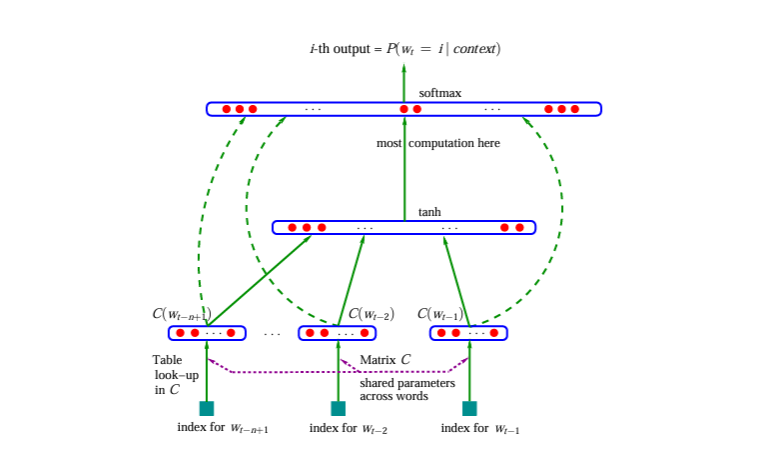

### We are going develope above network in python
### Our parameter's will be 1) weights and biases of the last linear layer before soft max 2) weights and biases the fully connected layer before tanh 3) embedding vector's of the embeding layer

## Imports

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib inline to creating seperate window for matplotlib figures it will draw it in cell output instead

## Read dataset

In [4]:
words = open("/kaggle/input/eureka-labs/names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars     = sorted(list(set(''.join(words))))
stoi      = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos      = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [55]:
# build dataset

block_size = 3 # context length : how many characters do we take to predict next one
X, Y       = [],[]

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] #crop and apppend
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [56]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## Creating input layer and embedings

### in the paper they have developed 17000 * 30 shape lookup table. But as we are working on character level we will developen 2 * 27 shape look up table here 2 is random we can change it

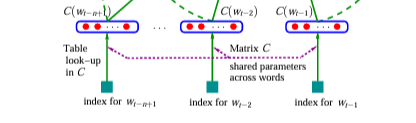

In [9]:
C = torch.randn((27,2)) #Random initialization and we will optmize it while training

In [10]:
C[5]

tensor([-0.1813, -1.4164])

In [11]:
#we can produce the same using one hot encoding
one_hot_encoded = F.one_hot(torch.tensor(5), num_classes=27).float()
print(one_hot_encoded)
emb_temp = one_hot_encoded @ C
emb_temp, C[5]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


(tensor([-0.1813, -1.4164]), tensor([-0.1813, -1.4164]))

In [12]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [13]:
emb[0]

tensor([[ 0.5007, -1.2898],
        [ 0.5007, -1.2898],
        [ 0.5007, -1.2898]])

In [14]:
emb[:,0,:].shape

torch.Size([32, 2])

## Creating hidden layer
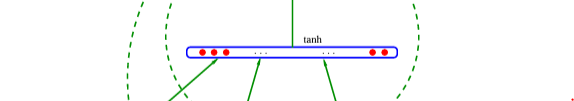

In [15]:
W1 = torch.randn((6,100)) # 6 = 3*2 last dimensions of the embedings ->DISCUSS
b1 = torch.randn(100)

In [16]:
# emb @ W1 + b1

In [17]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]], 1).shape

torch.Size([32, 6])

In [18]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [19]:
emb.shape

torch.Size([32, 3, 2])

In [20]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #-1 means pytroch will find the dimension
h.shape

torch.Size([32, 100])

## Creating the last layer
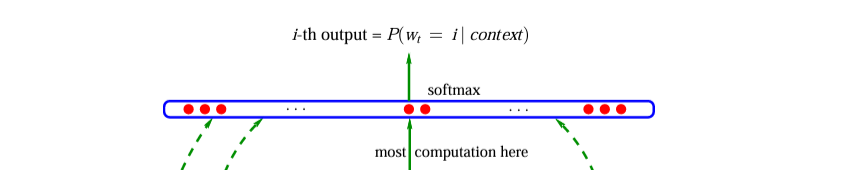

In [21]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2 + b2

In [23]:
logits.shape, logits[0]

(torch.Size([32, 27]),
 tensor([ -1.5546,   2.8167,  -1.1217,  -4.2808,  -4.8482,  -3.4705,  -4.5492,
          -8.4049,   0.5102,  -6.7965,   9.5732,   2.3519,   0.1928,   6.5513,
           9.2350,   2.6512, -11.4350, -12.7150,   6.3120,  -5.0777,   3.6491,
          -8.0323,   3.6366,   4.8818,  -2.3170,  -9.7858,   5.6871]))

In [24]:
counts = logits.exp()
counts.shape, counts[0]

(torch.Size([32, 27]),
 tensor([2.1128e-01, 1.6721e+01, 3.2571e-01, 1.3831e-02, 7.8422e-03, 3.1101e-02,
         1.0576e-02, 2.2376e-04, 1.6656e+00, 1.1176e-03, 1.4374e+04, 1.0506e+01,
         1.2127e+00, 7.0015e+02, 1.0250e+04, 1.4170e+01, 1.0810e-05, 3.0057e-06,
         5.5112e+02, 6.2342e-03, 3.8440e+01, 3.2480e-04, 3.7962e+01, 1.3187e+02,
         9.8566e-02, 5.6244e-05, 2.9503e+02]))

In [26]:
prob = counts / counts.sum(1, keepdims=True)     #counts.sum(1, keepdims=True)- take the sum of look up columnwise and transpose it 
prob.shape, prob[0]

(torch.Size([32, 27]),
 tensor([7.9960e-06, 6.3282e-04, 1.2326e-05, 5.2343e-07, 2.9679e-07, 1.1770e-06,
         4.0025e-07, 8.4682e-09, 6.3034e-05, 4.2297e-08, 5.4398e-01, 3.9759e-04,
         4.5894e-05, 2.6497e-02, 3.8791e-01, 5.3628e-04, 4.0911e-10, 1.1375e-10,
         2.0857e-02, 2.3593e-07, 1.4548e-03, 1.2292e-08, 1.4367e-03, 4.9907e-03,
         3.7302e-06, 2.1285e-09, 1.1165e-02]))

In [27]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.6300)

In [33]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.6300)

## Forward pass

In [ ]:
#  #forward pass
#     emb    = C[X[ix]]
#     h      = torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
#     logits = h @ W2 + b2 # 32,27
#     # counts = logits.exp()
#     # prob   = counts/counts.sum(1,keepdims=True)
#     # loss   = -prob[torch.arange(32), Y].log().mean()
#     loss = F.cross_entropy(logits, Y[ix])

In [66]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [78]:
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27,2), generator=g)

W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)

W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C,W1,b1,W2,b2]

In [79]:
for p in parameters:
    p.requires_grad = True

### Time to find best learning rate between a range

In [70]:
10 ** -3

0.001

In [80]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
#lrs # tensor having range between 0.001 to 1

#### It was taking some time in for a batch so we created mini batches here and started running fast

In [88]:
lri   = []
lossi = []

for i in range(10000):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    #forward pass
    emb    = C[X[ix]]
    h      = torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
    logits = h @ W2 + b2 # 32,27
    loss   = F.cross_entropy(logits, Y[ix])
    #print(loss)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lr)
#     lossi.append(loss.item())

In [89]:
emb    = C[X]
h      = torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits = h @ W2 + b2 # 32,27
loss   = F.cross_entropy(logits, Y)
loss

tensor(2.3558, grad_fn=<NllLossBackward0>)

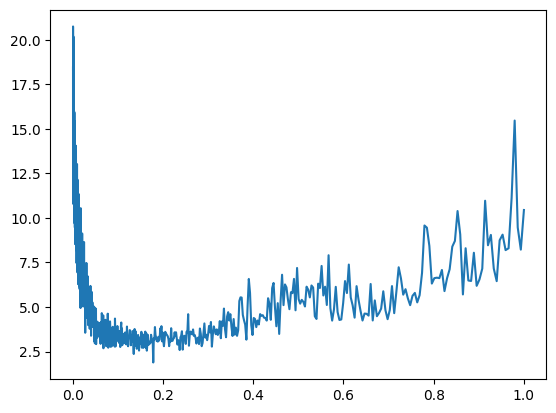

In [83]:
plt.plot(lri,lossi)

In [53]:
logits.max(1)

torch.return_types.max(
values=tensor([13.4213, 17.9807, 20.6844, 20.7377, 16.8686, 13.4213, 16.1256, 14.2811,
        16.0232, 18.5140, 16.0864, 21.0648, 13.4213, 17.2718, 17.2786, 20.2150,
        13.4213, 16.7166, 15.2725, 17.2157, 18.7042, 16.1187, 11.0077, 10.8044,
        15.5960, 13.4213, 16.3001, 17.0989, 12.8318, 16.3000, 19.2391, 16.2045],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [54]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## Data spliting
### 80% train - to train NN parameter's
### 10% val   - to train NN Hyper parameter's
### 10% test  - to test accuracy on unseen data

In [98]:
def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict next one
    X, Y       = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] #crop and apppend

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2])

## training NN now

In [132]:
#As we have tiny network previously it was underfitting so increasing the size on NN
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27,10), generator=g)

W1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)

W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

In [133]:
sum(p.nelement() for p in parameters)

11897

In [148]:
lri   = []
lossi = []
stepi = []

for i in range(200000):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb    = C[Xtr[ix]]
    h      = torch.tanh(emb.view(-1,30) @ W1 + b1) #32,100
    logits = h @ W2 + b2 # 32,27
    loss   = F.cross_entropy(logits, Ytr[ix])
    #print(loss)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
#     lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

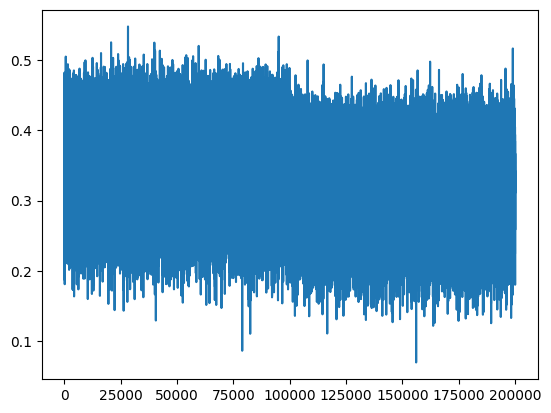

In [149]:
plt.plot(stepi,lossi)

In [150]:
emb    = C[Xtr]
h      = torch.tanh(emb.view(-1,30) @ W1 + b1) #32,100
logits = h @ W2 + b2 # 32,27
loss   = F.cross_entropy(logits, Ytr)
loss

tensor(2.0756, grad_fn=<NllLossBackward0>)

In [151]:
emb    = C[Xval]
h      = torch.tanh(emb.view(-1,30) @ W1 + b1) #32,100
logits = h @ W2 + b2 # 32,27
loss   = F.cross_entropy(logits, Yval)
loss

tensor(2.1490, grad_fn=<NllLossBackward0>)

## Visualizing the embeddings before it's dimensions from 2 to bigger cause we think that we have increased the size of hidden layer tanh still we don't much improvement in performance it may be cause small embedding dimensions

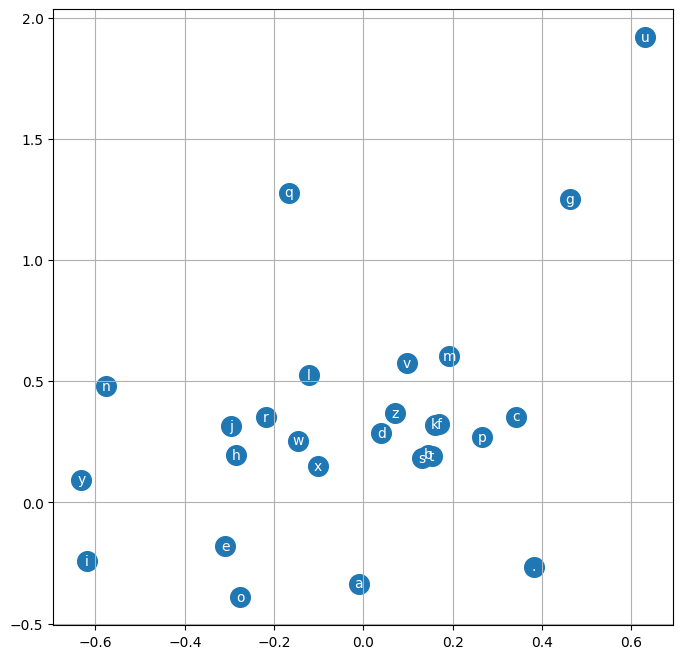

In [128]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
    
plt.grid('minor')

## Inference time

In [155]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    
    while(True):
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h   = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            #util . comes again
            break
    print(''.join(itos[i] for i in out))

mohailmyah.
see.
madhrysley.
thruthadrie.
cadered.
elin.
shy.
jen.
eden.
van.
naraelyzion.
kalin.
shubergahimies.
kindreeller.
novana.
ubrence.
rhylene.
els.
kayshuston.
mahil.
